| **Chapter**                   | 8:  Spatial dynamics of epidemics                                                                                         |
| ----------------------------- |---------------------------------------------------------------------------------------------------------------------------|
| **Computational Note**        | 8.x: Placing testing sites in Manhattan                                                                                   |
| **Package prerequisites**     | [osmnx](https://osmnx.readthedocs.io/en/stable/), [igraph](https://igraph.org/python/), [spopt](https://pysal.org/spopt/) |


# Placing testing sites in Manhattan

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import osmnx
import igraph as ig
from spopt.locate import PMedian
import pulp
import networkx as nx
import random
import warnings
from tqdm import auto as tqdm

SMALL_SIZE = 5
matplotlib.rc("font", size=SMALL_SIZE)
matplotlib.rc("axes", titlesize=SMALL_SIZE)

random.seed(1234)

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}


In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p pysal,cplex,spopt

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

pysal: 2.6.0
cplex: not installed
spopt: 0.4.1

matplotlib: 3.5.2
networkx  : 2.8.4
igraph    : 0.9.9
pandas    : 1.4.2
numpy     : 1.21.6
tqdm      : 4.64.0
osmnx     : 1.2.0
pulp      : 2.6.0



# Setting parameters

In [3]:
location = "Manhattan, NY"
p = 3

# Importing map data

## Importing the connectivity graph

In [4]:
%%time
graph = osmnx.graph_from_place(location, network_type="drive", simplify=False)
osmnx.distance.add_edge_lengths(graph)

CPU times: user 10.2 s, sys: 487 ms, total: 10.7 s
Wall time: 10.8 s


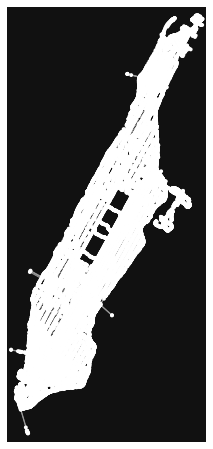

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
osmnx.plot_graph(graph)

## Converting the connectivity graph to `igraph`

In [6]:
osm_ids = list(graph.nodes)
graph = nx.relabel.convert_node_labels_to_integers(graph)

osm_id_vals = {k: v for k, v in zip(graph.nodes, osm_ids)}
nx.set_node_attributes(graph, osm_id_vals, "osmid")

i_graph = ig.Graph(directed=True)
i_graph.add_vertices(graph.nodes)
i_graph.add_edges(graph.edges())
i_graph.vs["osmid"] = osm_ids
i_graph.es["length"] = list(nx.get_edge_attributes(graph, "length").values())


## Importing building footprints

In [7]:
building_filter = ["yes", "dormitory", "terrace", "apartments", "residential", "house", "semidetached_house", "detached", "condominium"]

In [8]:
%%time
buildings = osmnx.geometries.geometries_from_place(location, tags={"building": True})[["geometry", "building"]]
buildings = buildings[buildings.building.isin(building_filter)]
buildings = buildings[buildings.geometry.apply(lambda x: x.type != "Point")]
buildings = buildings.reset_index()
buildings["nearest_node"] = osmnx.distance.nearest_nodes(graph, buildings.geometry.centroid.x, buildings.geometry.centroid.y)

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
<timed exec>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

<timed exec>:5: 

CPU times: user 19 s, sys: 2.4 s, total: 21.4 s
Wall time: 21.8 s


In [9]:
nodes, edges = osmnx.graph_to_gdfs(graph, nodes=True, edges=True, node_geometry=True)

In [10]:
len(buildings)

44302

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


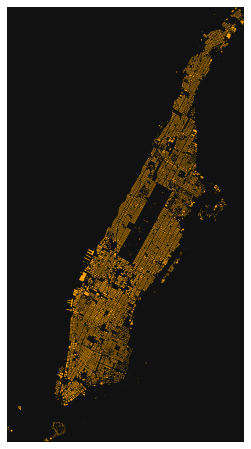

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [11]:
osmnx.plot_footprints(buildings)

## Importing footprints for eligible sites

In [12]:
%%time
eligible_sites = osmnx.geometries.geometries_from_place(location, tags={"amenity": ["hospital"]})[["geometry"]]
eligible_sites["nearest_node"] = osmnx.distance.nearest_nodes(graph, eligible_sites.geometry.centroid.x, eligible_sites.geometry.centroid.y)
eligible_sites = eligible_sites[eligible_sites.geometry.apply(lambda x: x.type != "Point")]
eligible_sites = eligible_sites.reset_index()

CPU times: user 290 ms, sys: 23.6 ms, total: 314 ms
Wall time: 327 ms


<timed exec>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

<timed exec>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [13]:
len(eligible_sites)

20

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


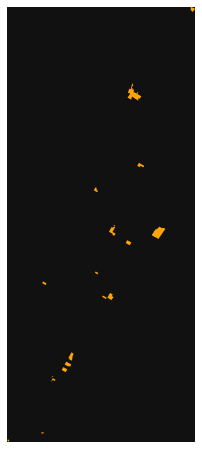

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [14]:
osmnx.plot_footprints(eligible_sites)

# Location optimisation

## Calculating cost matrix

In [15]:
def get_distance(source_node, destination_node) -> float:
   return sum(list(map(lambda x: i_graph.es[x]["length"], i_graph.get_shortest_paths(v=source_node, to=destination_node, weights="length", output="epath")[0])))

In [16]:
cost_matrix = np.zeros(shape=(len(buildings), len(eligible_sites)), dtype=float)

In [17]:
%%time

for i in tqdm.notebook_trange(len(buildings)):
    for j in range(len(eligible_sites)):
        cost_matrix[i, j] = get_distance(buildings.loc[i, "nearest_node"], eligible_sites.loc[j, "nearest_node"])
        cost_matrix_idx = buildings.index[i]

  0%|          | 0/44302 [00:00<?, ?it/s]

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_64123/3933603623.py:2: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  return sum(list(map(lambda x: i_graph.es[x]["length"], i_graph.get_shortest_paths(v=source_node, to=destination_node, weights="length", output="epath")[0])))


CPU times: user 2h 46min 4s, sys: 15min 33s, total: 3h 1min 38s
Wall time: 11h 53min 23s


In [18]:
cost_df = pd.DataFrame(cost_matrix, index=buildings.index)

In [19]:
cost_df = cost_df.drop(8, axis=1)

In [20]:
cost_df = cost_df.loc[(cost_df != 0).any(axis=1)]

In [21]:
cost_df

0         1         2         3         4          5   \
0      11809.162  4372.993  4096.222  3656.245  4802.430   5501.318   
1      10611.567  4053.964  3766.880  3326.903  4120.563   4299.113   
2      11053.244  3617.075  3340.304  2900.327  4046.512   4745.400   
7      17915.765  5666.523  5949.532  6569.557  5062.345  12040.188   
8       5336.361  8807.005  8519.921  8079.944  8754.340   1474.466   
...          ...       ...       ...       ...       ...        ...   
44297  16632.598  3513.337  3796.346  4416.371  3280.148  10319.994   
44298  10945.917  3318.792  3042.021  2602.044  4088.876   4638.073   
44299   8509.637  6237.331  5955.334  5515.357  6074.529   5106.197   
44300   8457.750  6289.218  6007.221  5567.244  6126.416   5054.310   
44301  16147.989  4131.184  4414.193  5034.218  3364.306  10182.527   

              6          7          9          10        11        12  \
0      11549.242   7656.232   5047.928   2403.905  5511.290  1570.042   
1      10351.647   7139.265   3845.723   2452.204  4829.423  1619.811   
2      10793.324   6900.314   4292.010   1647.987  4755.372   814.124   
7      17780.944   2758.499  11586.798  10165.279  5002.042  9331.416   
8       5076.441  11711.717   1808.034   5256.401  9463.200  5456.772   
...          ...        ...        ...        ...       ...       ...   
44297  16372.678    634.873   9866.604   8012.093  2848.856  7178.230   
44298  10685.997   6602.031   4184.683   1540.660  4797.736   706.797   
44299   8374.816   9031.906   4652.807   4563.715  6783.389  3731.448   
44300   8322.929   9083.793   4600.920   4615.602  6835.276  3783.335   
44301  16013.168   1689.047   9729.137   8629.940  3466.703  7796.077   

             13         14         15         16         17         18  \
0      3034.666   4081.703   7738.231   8133.901  15434.614   8629.974   
1      1767.599   3542.246   6339.108   7170.284  14774.760   7637.739   
2      2278.748   3325.785   6982.313   7377.983  14678.696   7874.056   
7      9719.547  11487.932  13385.850  14912.476  22484.009   1603.588   
8      3782.760   2583.251   1094.732   2891.606   9718.472  11947.917   
...         ...        ...        ...        ...        ...        ...   
44297  7999.353   9334.746  12199.143  13192.282  20811.427   1341.587   
44298  2171.421   3218.458   6875.556   7270.656  14571.369   7916.420   
44299  3733.424   5276.863   4226.899   7590.716  13474.688   8805.291   
44300  3724.772   5224.976   4175.012   7538.829  13422.801   8857.178   
44301  8021.508   9796.155  11618.074  13054.815  20716.233    657.086   

             19  
0      4020.938  
1      2594.183  
2      3265.020  
7      8950.063  
8      5247.063  
...         ...  
44297  7855.669  
44298  3474.825  
44299  1254.953  
44300  1306.840  
44301  7233.341  

[44066 rows x 19 columns]

## Filtering buildings and cost matrix to eliminate unreachable locations

In [22]:
buildings = buildings.iloc[cost_df.index.to_list()]

## $p$-median optimisation

In [23]:
cost_matrix = cost_df.to_numpy()

In [24]:
pmedian = PMedian.from_cost_matrix(cost_matrix, weights=np.ones(cost_matrix.shape[0]), p_facilities=p)

In [25]:
%%time

pmedian.solve(pulp.COIN_CMD())

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  6 2022 

command line - cbc /var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/3c683fbdc7dd4022b8240cbf088ceaad-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/3c683fbdc7dd4022b8240cbf088ceaad-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 881326 COLUMNS
At line 5904879 RHS
At line 6786201 BOUNDS
At line 7623475 ENDATA
Problem MODEL has 881321 rows, 837273 columns and 2511781 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.10241e+08 - 4248.01 seconds
Cgl0004I processed model has 881321 rows, 837273 columns (837273 integer (837273 of which binary)) and 2511781 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.10241e+08
Cbc0038I Before mini branch and bound, 837273 integers at bound fixed and 0 continuous
Cbc0

In [26]:
pmedian.facility_client_array()
pmedian.client_facility_array()

In [27]:
selected_facilities = np.unique(pmedian.cli2fac).tolist()

In [28]:
selected_facilities

[4, 12, 15]

In [29]:
buildings["assigned_facility"] = list(map(lambda x: x[0], pmedian.cli2fac))

In [30]:
conversion = dict(zip(buildings.assigned_facility.unique(), list("ABCDEFGHIJKLMNOPQ")[:len(buildings.assigned_facility.unique())]))

In [31]:
buildings["assigned_facility_label"] = buildings.assigned_facility.apply(lambda x: conversion[x])

In [32]:
selected_sites = eligible_sites.iloc[selected_facilities]
selected_sites["label"] = selected_sites.index.map(lambda x: conversion[x])

buildings["assigned_facility_distance"] = buildings.apply(lambda x: get_distance(x.nearest_node, eligible_sites.iloc[x.assigned_facility].nearest_node), axis=1)

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [33]:
selected_sites

element_type      osmid                                           geometry  \
4           way  249663131  POLYGON ((-73.98280 40.73437, -73.98273 40.734...   
12          way  562360129  POLYGON ((-73.95618 40.76380, -73.95582 40.764...   
15          way  562510587  POLYGON ((-73.96054 40.80414, -73.96017 40.804...   

    nearest_node label  
4          13545     B  
12         26435     A  
15          8031     C

# Plotting results

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_64123/691114656.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_centers = selected_sites.geometry.centroid
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= Loos

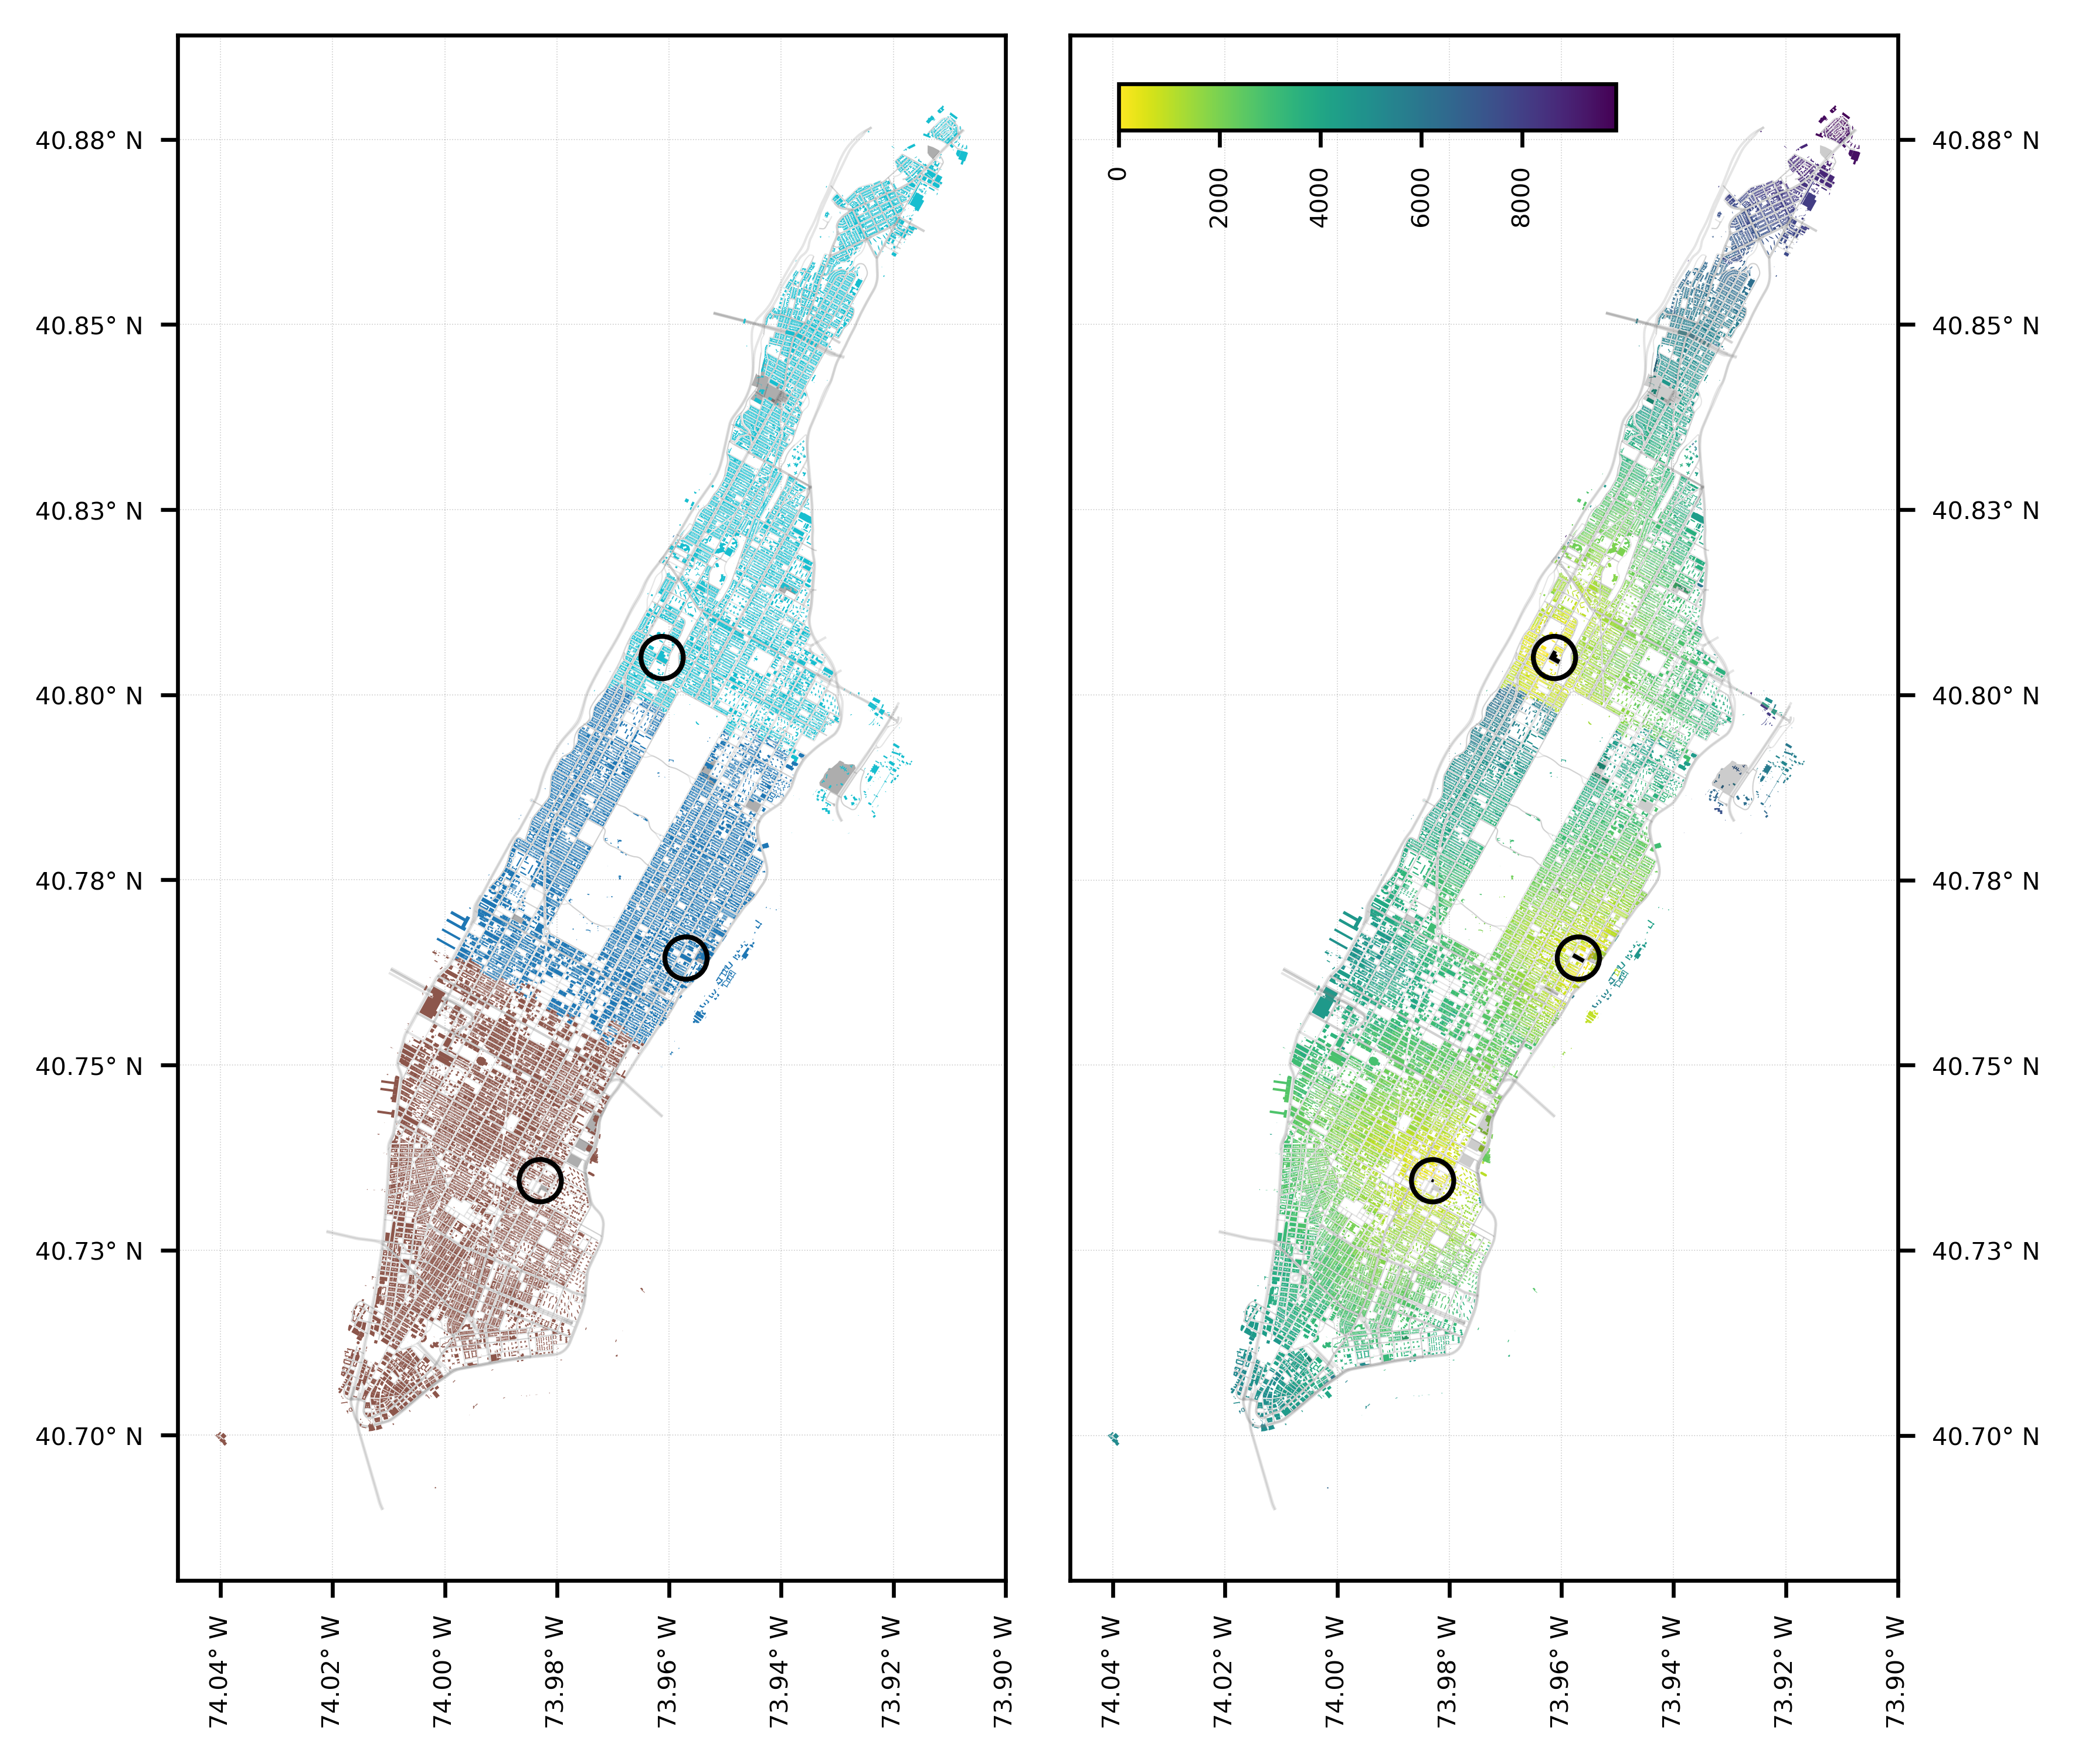

In [37]:
nodes, edges = osmnx.graph_to_gdfs(graph)

edges.geometry = edges.geometry.to_crs(4326)
selected_sites.geometry = selected_sites.geometry.to_crs(4326)
eligible_sites.geometry = eligible_sites.geometry.to_crs(4326)
buildings.geometry = buildings.geometry.to_crs(4326)

buildings_filtered = buildings[(buildings.apply(lambda x: np.min([x.geometry.centroid.distance(site.centroid) for site in selected_sites.geometry]) > 0.0002, axis=1)) & (buildings.assigned_facility_distance > 0) & (~buildings.osmid.isin(selected_sites.osmid))]

circle_centers = selected_sites.geometry.centroid
circle_centers.reset_index()
circle_size=75
middle_scale = "tab10"
bottom_scale = "viridis_r"

fig = plt.figure(facecolor="w", figsize=(6, 6), dpi=600)
ax = fig.add_subplot(121, axisbelow=True)

arterial_roads = edges.loc[edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]
secondary_roads = edges.loc[edges.highway.isin(["secondary", "tertiary", "residential"])]

arterial_roads.plot(ax=ax, lw=0.5, color="gray", alpha=0.2, zorder=3)
secondary_roads.plot(ax=ax, lw=0.25, color="gray", alpha=0.2, zorder=3)

eligible_sites.plot(ax=ax, color="k", alpha=0.2, zorder=4)

buildings_filtered.plot("assigned_facility_label", cmap=middle_scale, ax=ax, zorder=5)

eligible_sites.plot(ax=ax, color="k", alpha=0.15, zorder=4)

selected_sites.plot("label", ax=ax, cmap=middle_scale, zorder=9, legend=False)

ax.scatter(circle_centers.x, circle_centers.y, marker="o", edgecolors="k", facecolors="none", s=circle_size, zorder=7)

ax.tick_params(axis="x", labelsize=5, rotation=90, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.tick_params(axis="y", labelsize=5, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° W"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° N"))
ax.grid()

ax = fig.add_subplot(122, axisbelow=True)

arterial_roads.plot(ax=ax, lw=0.5, color="gray", alpha=0.2, zorder=3)
secondary_roads.plot(ax=ax, lw=0.25, color="gray", alpha=0.2, zorder=3)

eligible_sites.plot(ax=ax, color="k", alpha=0.2, zorder=4)

selected_sites.plot(ax=ax, color="k", zorder=5)

ax.scatter(circle_centers.x, circle_centers.y, marker="o", edgecolors="k", facecolors="none", s=circle_size, zorder=7)

dist = buildings_filtered.plot("assigned_facility_distance", ax=ax, cmap=bottom_scale, legend=False)

norm = colors.Normalize(vmin=buildings.assigned_facility_distance.min(), vmax=buildings.assigned_facility_distance.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap=bottom_scale)

ax.tick_params(axis="x", labelsize=5, rotation=90, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.tick_params(axis="y", labelsize=5, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° W"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° N"))
ax.yaxis.tick_right()
ax.grid()

fig.tight_layout()

axins = inset_axes(ax, width="60%", height="3%", loc="upper left", borderpad=1)

ax_cbar = fig.colorbar(cbar, cax=axins, orientation="horizontal")
axins.tick_params(axis="x", labelsize=2, rotation=90)

plt.xticks(fontsize=SMALL_SIZE)
plt.savefig("testing_site_loc_opt.pdf")